In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt 
import datetime
from sklearn.metrics import fbeta_score,confusion_matrix
import lightgbm as lgb
from mochi import runXGB,f_beta_01,runLGBM
import xgboost as xgb

In [21]:
import xgboost as xgb

In [2]:
class Config:
    pass
config = pd.read_pickle('config.pkl')
data_path = config.data_path
feature_path = config.feature_path
print(dir(config))
print(config.feature_dict.keys())

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'data_path', 'feature_dict', 'feature_path', 'model_features', 'result_path', 'single_module_validation_indice_set', 'trade_train_size', 'train_2_6_index']
dict_keys(['trade_and_recent_login_comparing', 'recent_login_detail', 'trade_detail_feature', 'login_trade_hist_stats', 'llc_user_habbit', 'hcc_user_habbit', 'hcc_properties', 'hcc_target_encoding', 'login_detail_new_features', 'hcc_mult_target_encoding', 'hcc_user_trade_habbit', 'hcc_trade_properties'])


In [3]:
features =   (config.feature_dict['trade_detail_feature']+
              config.feature_dict['recent_login_detail']+
              config.feature_dict['trade_and_recent_login_comparing']+
              config.feature_dict['login_trade_hist_stats']+
              config.feature_dict['llc_user_habbit']+
             config.feature_dict['hcc_user_habbit']+
              config.feature_dict['hcc_properties']+
            config.feature_dict['hcc_target_encoding']+
                    config.feature_dict['login_detail_new_features']+
              config.feature_dict['hcc_trade_properties']+
              config.feature_dict['hcc_mult_target_encoding']+
              config.feature_dict['hcc_user_trade_habbit']
             )
feature_sequence_list = []
for feature in features:
    feature_sequence_list.append(pd.read_pickle(feature_path+feature+'.pkl').reshape(-1,1))
    
trade_tt_mat = np.hstack(feature_sequence_list)
#trade_tt_mat[trade_tt_mat==-10]=np.nan

validation_tuple_list = config.single_module_validation_indice_set
train_labels = pd.read_pickle(data_path+'trade_train_label.pkl')

In [4]:
top_features =  config.model_features['model_I_top300']
top_features_ori_index = [features.index(x) for x in top_features]
trade_tt_top = trade_tt_mat[:,top_features_ori_index]

In [22]:
def f_beta_01(preds, train_data, threshold = 0.5):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(labels, preds > threshold,0.1),True

def f_beta_01_xgb(preds, train_data, threshold = 0.5):
    labels  = train_data.get_label()
    return 'fbeta_score_01',fbeta_score(labels, preds > threshold,0.1)

#xgb for binary
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, 
     seed_val=0, early_stop = 20,num_rounds=10000, eta = 0.1,
     subsample = 0.75,colsample_bytree = 0.75,eval_metric = 'auc',feval = None,
     max_depth = 6,cv_dict = None,verbose_eval=True):
    
    param = {}
    param['objective'] = 'binary:logistic'
    param['eta'] = eta
    param['max_depth'] = max_depth
    param['silent'] = 1
    #param['num_class'] = 3
    param['eval_metric'] = eval_metric
    param['min_child_weight'] = 1
    param['subsample'] = subsample
    param['colsample_bytree'] = colsample_bytree
    param['seed'] = seed_val
    num_rounds = num_rounds

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y,feature_names=feature_names)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y,feature_names=feature_names)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,
        early_stopping_rounds=early_stop,evals_result = cv_dict,
        verbose_eval = verbose_eval,feval = feval)
    else:
        xgtest = xgb.DMatrix(test_X,feature_names=feature_names)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    return pred_test_y, model

In [6]:
cv_scores = []
cv_result = []
models = []
i = 0

for train_indice,val_indice in validation_tuple_list:
    #print trade_train_val.iloc[train_indice]['month'].unique(),trade_train_val.iloc[val_indice]['month'].unique()
    #print trade_train_val.iloc[train_indice].shape,trade_train_val.iloc[val_indice].shape
    result_dict = {}
    
    #filter the features
    dev_X, val_X = trade_tt_top[train_indice], trade_tt_top[val_indice]
    dev_y, val_y = train_labels.iloc[train_indice].values, train_labels.iloc[val_indice].values

    """
    preds, model = runLGBM(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose=100,eta=0.02,
                          early_stop=None,num_rounds=500,watch_dict=result_dict,feval = f_beta_01)
    """
    preds, model = runXGB(dev_X, dev_y, val_X, val_y,feature_names=top_features,verbose_eval=100,eta=0.02,
                          early_stop=None,num_rounds=500,cv_dict=result_dict,feval = f_beta_01_xgb ,max_depth =4)
    
    #result_f_beta = f_beta_01(val_y.values, preds>0.5)
    result_f_beta  = fbeta_score( val_y,preds > 0.8, 0.1)
    
    cv_scores.append(result_f_beta)
    cv_result.append(result_dict)
    models.append(model)
    i+=1
    print('f_beta score for the turn '+str(i)+' is '+str(result_f_beta))

print('The mean of the cv_scores is:',np.mean(cv_scores))

[0]	train-auc:0.882371	test-auc:0.855838	train-fbeta_score_01:0.964524	test-fbeta_score_01:0.862098
[100]	train-auc:0.985347	test-auc:0.971877	train-fbeta_score_01:0.958559	test-fbeta_score_01:0.882071
[200]	train-auc:0.99273	test-auc:0.989587	train-fbeta_score_01:0.967335	test-fbeta_score_01:0.898731
[300]	train-auc:0.996194	test-auc:0.99108	train-fbeta_score_01:0.967767	test-fbeta_score_01:0.895561
[400]	train-auc:0.9982	test-auc:0.990771	train-fbeta_score_01:0.97209	test-fbeta_score_01:0.90303
[499]	train-auc:0.99913	test-auc:0.990448	train-fbeta_score_01:0.977948	test-fbeta_score_01:0.893805
f_beta score for the turn 1 is 0.915206032145
[0]	train-auc:0.928398	test-auc:0.807046	train-fbeta_score_01:0.957272	test-fbeta_score_01:0.795155
[100]	train-auc:0.987671	test-auc:0.95393	train-fbeta_score_01:0.9708	test-fbeta_score_01:0.858613
[200]	train-auc:0.995655	test-auc:0.974451	train-fbeta_score_01:0.970284	test-fbeta_score_01:0.871612
[300]	train-auc:0.998475	test-auc:0.975858	train-f

In [7]:
#finding the best iteration
pd_list = []
for dic in cv_result:
    pd_list.append(pd.DataFrame(dic['test']))
for i in range(len(pd_list)):
    pd_list[i].columns = pd_list[i].columns+'_'+str(i)
validation_result = pd.concat(pd_list,axis = 1)
validation_result['auc_avg'] = validation_result.apply(lambda x : np.mean([x.auc_0,x.auc_1,x.auc_2,x.auc_3,x.auc_4]),axis = 1)

validation_result['fbeta_avg'] = validation_result.apply(lambda x : np.mean([x.fbeta_score_01_0,x.fbeta_score_01_1,
                                                                     x.fbeta_score_01_2,x.fbeta_score_01_3,
                                                                    x.fbeta_score_01_4]),axis=1)

print(validation_result['auc_avg'].idxmax())
print(validation_result['fbeta_avg'].idxmax())

365
185


In [8]:
train_X = trade_tt_mat[config.train_2_6_index]
test_X = trade_tt_mat[config.trade_train_size:]
train_y = train_labels[config.train_2_6_index]

preds_185, _ = runXGB(train_X, train_y, test_X, feature_names=features,verbose_eval=100,eta=0.02,
                          early_stop=None,num_rounds=185,cv_dict=None,max_depth = 4)


In [9]:
preds_365, _ = runXGB(train_X, train_y, test_X, feature_names=features,verbose_eval=100,eta=0.02,
                          early_stop=None,num_rounds=365,cv_dict=None,max_depth = 4)

### result visulization

101
48
22
7


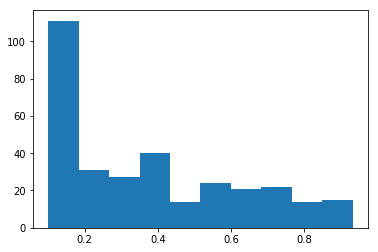

In [13]:
%matplotlib inline
plt.hist(preds_185[preds_185>0.1])
print(np.sum(preds_185>0.5))
print(np.sum(preds_185>0.7))
print(np.sum(preds_185>0.8))
print(np.sum(preds_185>0.9))

136
72
47
29


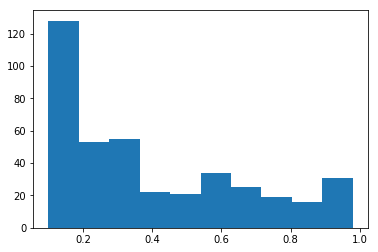

In [17]:
%matplotlib inline
plt.hist(preds_365[preds_365>0.1])
print(np.sum(preds_365>0.5))
print(np.sum(preds_365>0.7))
print(np.sum(preds_365>0.8))
print(np.sum(preds_365>0.9))

In [23]:
preds_500, _ = runXGB(train_X, train_y, test_X, feature_names=features,verbose_eval=100,eta=0.02,
                          early_stop=None,num_rounds=500,cv_dict=None,max_depth = 4)

168
95
58
35


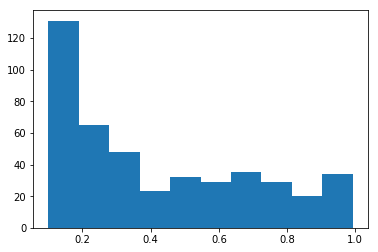

In [24]:
%matplotlib inline
plt.hist(preds_500[preds_500>0.1])
print(np.sum(preds_500>0.5))
print(np.sum(preds_500>0.7))
print(np.sum(preds_500>0.8))
print(np.sum(preds_500>0.9))